In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import os
# from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [2]:
from dataset_utils import split_dataset_by_brand, split_dataset, reset_index
from sklearn.preprocessing import LabelEncoder

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda


In [4]:
import pandas as pd
clf_dataset = pd.read_csv('./clf_data.csv')
lb = LabelEncoder()
lb.fit(list(set(clf_dataset['Brand'])))
print(lb.classes_)
clf_dataset['label'] = lb.transform(clf_dataset['Brand'])
print(clf_dataset)
train,val,test = split_dataset(split_dataset_by_brand(clf_dataset))
train_d = reset_index(train.sample(frac=1))
val_d = reset_index(val.sample(frac=1))
test_d = reset_index(test.sample(frac=1))


['audemarspiguet' 'breitling' 'cartier' 'gucci' 'iwc' 'movado' 'nomos'
 'omega' 'patekphilippe' 'rolex' 'seiko' 'zenith']
      Unnamed: 0                     img   Brand  label
0              0       0-iwc-13109.0.png     iwc      4
1              1        1-iwc-4899.0.png     iwc      4
2              2       2-iwc-10139.0.png     iwc      4
3              3        3-iwc-3239.0.png     iwc      4
4              4        4-iwc-8499.0.png     iwc      4
...          ...                     ...     ...    ...
3637        3637  3637-zenith-2750.0.png  zenith     11
3638        3638  3638-zenith-4895.0.png  zenith     11
3639        3639  3639-zenith-5950.0.png  zenith     11
3640        3640  3640-zenith-6409.0.png  zenith     11
3641        3641  3641-zenith-4999.0.png  zenith     11

[3642 rows x 4 columns]
242 272 303
242 272 303
240 270 300
245 275 307
245 275 307
240 270 301
246 276 308
240 270 300
243 273 304
242 272 303
242 272 303
242 272 303


In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
transform = transforms.Compose([
     transforms.Resize((300, 300)),
     transforms.CenterCrop((200, 200)),
#      transforms.RandomCrop((80, 80)),
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.RandomRotation(degrees=(-90, 90)),
#      transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop((200, 200)),
        transforms.RandomRotation(degrees=(-90, 90)),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
class Watch_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'img'])
        image = Image.open(img_name).convert('RGB')
        #image = image.convert('RGB')
#         image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'label'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
train = Watch_Dataset(train_d,'./scraper/images',data_transforms['train'])
val = Watch_Dataset(val_d,'./scraper/images',data_transforms['val'])
test = Watch_Dataset(test_d,'./scraper/images',data_transforms['val'])

In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size=20)
validation_loader = torch.utils.data.DataLoader(val, batch_size=20)

In [9]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
7
1
2
3


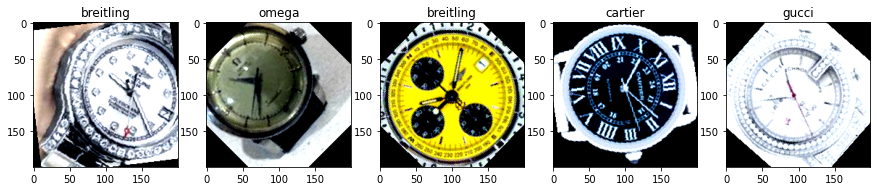

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
watch_types = { i:lb.classes_[i] for i in range(len(lb.classes_))}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
#         print(i,images[i])
        image, label = images[i], labels[i]
        print(label.item())
        ax.set(title = f"{watch_types[label.item()]}") # add label
        ax.imshow(img_display(image)) # add image
        

In [281]:
images[0].size()


torch.Size([3, 80, 80])

# MODEL


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.neurons = self.linear_input_neurons()
        self.fc1 = nn.Linear(self.neurons,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 12)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
#         print(x.size())
        x = x.view(-1, self.neurons) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x
    
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.neurons = self.linear_input_neurons()
#         print(self.neurons)
#         self.fc1 = nn.Linear(self.neurons, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 12)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, self.neurons)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return F.log_softmax(x, dim=1)
    
    def size_before_fc(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))

        return x.size()


    # after obtaining the size in above method, we call it and multiply all elements of the returned size.
    def linear_input_neurons(self):
        size = self.size_before_fc(torch.rand(1, 3, 210, 210)) # image size: 64x32
        m = 1
        for i in size:
            m *= i

        return int(m)

    
net = Net()

In [17]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=12, bias=True)
)

In [11]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512, 12),
    nn.Softmax()
)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        target_ = target_.type(torch.long)
        data_, target_ = data_.to(device), target_.to(device)# on GPU
#         print(type(data_),type(target_))
#         data_ = data_.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
#         print(type(outputs),type(target_))
#         target_ = target_.type(torch.long)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            target_t = target_t.type(torch.long)
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
#             target_t = target_t.type(torch.long)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss <= valid_loss_min
        print(f'min_val:{valid_loss_min}, validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet18_pretr_softmax.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/20], Step [0/146], Loss: 2.9867
Epoch [1/20], Step [20/146], Loss: 2.6277
Epoch [1/20], Step [40/146], Loss: 2.1722
Epoch [1/20], Step [60/146], Loss: 2.1109
Epoch [1/20], Step [80/146], Loss: 2.1239
Epoch [1/20], Step [100/146], Loss: 1.7683
Epoch [1/20], Step [120/146], Loss: 1.2990
Epoch [1/20], Step [140/146], Loss: 1.3506

train loss: 2.1992, train acc: 26.9165
min_val:inf, validation loss: 1.5396, validation acc: 52.5000

Detected network improvement, saving current model
Epoch 2

Epoch [2/20], Step [0/146], Loss: 2.2360
Epoch [2/20], Step [20/146], Loss: 1.8026
Epoch [2/20], Step [40/146], Loss: 1.6031
Epoch [2/20], Step [60/146], Loss: 1.6136
Epoch [2/20], Step [80/146], Loss: 1.8880
Epoch [2/20], Step [100/146], Loss: 1.2043
Epoch [2/20], Step [120/146], Loss: 0.9054
Epoch [2/20], Step [140/146], Loss: 0.8427

train loss: 1.8726, train acc: 48.9172
min_val:27.712708711624146, validation loss: 1.3473, validation acc: 62.7778

Detected network improvement, savi

Epoch [17/20], Step [120/146], Loss: 0.0503
Epoch [17/20], Step [140/146], Loss: 0.1489

train loss: 0.6530, train acc: 95.8405
min_val:13.307181030511856, validation loss: 0.8914, validation acc: 78.6111

Epoch 18

Epoch [18/20], Step [0/146], Loss: 0.0592
Epoch [18/20], Step [20/146], Loss: 0.0148
Epoch [18/20], Step [40/146], Loss: 0.0156
Epoch [18/20], Step [60/146], Loss: 0.1201
Epoch [18/20], Step [80/146], Loss: 0.1183
Epoch [18/20], Step [100/146], Loss: 0.0143
Epoch [18/20], Step [120/146], Loss: 0.0087
Epoch [18/20], Step [140/146], Loss: 0.0205

train loss: 0.6226, train acc: 97.0780
min_val:13.307181030511856, validation loss: 0.8858, validation acc: 77.7778

Epoch 19

Epoch [19/20], Step [0/146], Loss: 0.0892
Epoch [19/20], Step [20/146], Loss: 0.2864
Epoch [19/20], Step [40/146], Loss: 0.1501
Epoch [19/20], Step [60/146], Loss: 0.0348
Epoch [19/20], Step [80/146], Loss: 0.0570
Epoch [19/20], Step [100/146], Loss: 0.0490
Epoch [19/20], Step [120/146], Loss: 0.1583
Epoch [1

In [13]:
model.load_state_dict(torch.load('resnet18_pretr.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 200, 200])
1
torch.Size([1, 3, 200, 200])
6
torch.Size([1, 3, 200, 200])
8
torch.Size([1, 3, 200, 200])
3
torch.Size([1, 3, 200, 200])
10


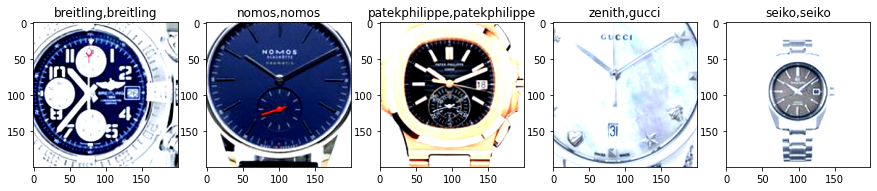

In [35]:


dataiter = iter(validation_loader)
images, labels = dataiter.next()
watch_types = { i:lb.classes_[i] for i in range(len(lb.classes_))}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
#         print(i,images[i])
        image, label = images[i], labels[i]
        inputs = image.clone()
        inputs = inputs.unsqueeze(dim=0)
        inputs = inputs.to(device)
        print(inputs.size())
#         label.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        print(label.item())
        ax.set(title = f"{watch_types[preds.item()]},{watch_types[label.item()]}") # add label
        ax.imshow(img_display(image)) # add image
        

In [38]:
test_loader = torch.utils.data.DataLoader(test, batch_size=20)
with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_loader):
            target_t = target_t.type(torch.long)
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
#             target_t = target_t.type(torch.long)
            loss_t = criterion(outputs_t, target_t)
#             batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        print('ACCURACY: ', 100*correct_t / total_t)
#         val_acc.append(100 * correct_t / total_t)
#         val_loss.append(batch_loss/len(validation_loader))
#         network_learned = batch_loss <= valid_loss_min
#         print(f'min_val:{valid_loss_min}, validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

ACCURACY:  78.1718963165075


In [55]:
def test_image(img, transform=None):
    image = Image.open(img).convert('RGB')
    
#         label = torch.tensor(self.img_data.loc[index, 'label'])
    if transform is not None:
        image = transform(image)
        inputs = image.clone()
        inputs = inputs.unsqueeze(dim=0)
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(outputs, 1)
        print(watch_types,"\n", outputs,"\n", preds, "\n\n",watch_types[preds.item()])

In [57]:
test_image('./scraper/test_images/Seiko_2.jpg', data_transforms['val'])

{0: 'audemarspiguet', 1: 'breitling', 2: 'cartier', 3: 'gucci', 4: 'iwc', 5: 'movado', 6: 'nomos', 7: 'omega', 8: 'patekphilippe', 9: 'rolex', 10: 'seiko', 11: 'zenith'} 
 tensor([[4.4330e-03, 1.2922e-03, 4.4155e-03, 9.5519e-02, 2.1245e-02, 1.1708e-02,
         6.6366e-02, 1.1817e-03, 1.0882e-01, 3.1254e-05, 5.8863e-01, 9.6351e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) 
 tensor([10], device='cuda:0') 

 seiko


In [50]:
op = torch.tensor([[-4.1811,  0.9286, -4.8205,  0.5879,  5.1605,  1.0632,  8.0410,  0.5682,
         -6.9226, -6.5105,  3.7662,  1.1762]], device='cuda:0')

In [52]:
nn.Softmax(dim=1)(op)

tensor([[4.5816e-06, 7.5881e-04, 2.4173e-06, 5.3972e-04, 5.2242e-02, 8.6814e-04,
         9.3113e-01, 5.2919e-04, 2.9539e-07, 4.4604e-07, 1.2956e-02, 9.7199e-04]],
       device='cuda:0')